---
title: tweetデータを用いた自然言語分類モデルをつくってみる②
date: 2024-12-03
description: tweetデータを用いた自然言語分類モデルをつくってみる①の続きです
categories: [kaggle, nlp, fastai]
toc: true
---

# 言語モデルを転移学習に使用してみる

[前の記事](https://akitsuyoshi.github.io/posts/tweet_kaggle/)の続きです。前回は`fastai`の`text_classifier_learner`関数を使用して、81% f1の精度で災害tweetを分類するモデルを作成しました。今回は更に、言語モデル(分類モデルと同じ`AWD_LSTM`モデル)を用いて転移学習をしていきます。前回の競技データに加えて、新たなtweetデータを言語モデルの学習に使用します。ベンチマークとして前回のスコア(81% f1)を用いますが、精度の向上は今回のポイントではありません。このノートの目的は、[ulmfit](https://arxiv.org/abs/1801.06146)で使用された転移学習方法をコードベースで見ていくことです。

次の図は、ulmfit アプローチのイメージです。三つのステップの内、今回はステップ2(language model)・3(classifier)を見ていきます。ステップ1は既に学習済みのモデルとして、fastaiに用意されたものを使用します。

![ulmfit アプローチ](ulmfit.png "ulmfit アプローチ")


--

以下、実装の流れです。

0. 必要なライブラリのインストール
1. データセットを用意
2. 言語モデルの作成
3. (言語モデルのembeddingを用いた)分類モデルの作成
4. まとめ
5. 参照リンク

## 必要なライブラリーのインストール

**データのインストール前に**、競技参加の同意・APIキー取得を行いましょう。

In [22]:
try: import fastkaggle
except ModuleNotFoundError:
    %pip install -Uq fastkaggle

from fastkaggle import *
from fastai.text.all import *

In [23]:
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.config/kaggle’: File exists


In [ ]:
# Ref: https://akitsuyoshi.github.io/posts/tweet_kaggle/

def combine_cols(df): return "xxfld 1 " + df["keyword"].fillna("") + " xxfld 2 " + df["location"].fillna("") + " xxfld 3 " + df["text"]

def random_splitter(df, val_pct=0.2):
    df = df.copy()
    df["uniq_text"] = df["text"].map(lambda x: hash(x))
    uniq_text = df["uniq_text"].unique()
    val_text_ids = set(random.sample(list(uniq_text), int(len(uniq_text) * val_pct)))

    trn_idx = df.index[~df["uniq_text"].isin(val_text_ids)].tolist()
    val_idx = df.index[df["uniq_text"].isin(val_text_ids)].tolist()
    return trn_idx, val_idx

def get_cls_dls(df, seq_len=72, vocab=None, backwards=False, splitter=random_splitter, bs=256):
    return DataBlock(
        blocks=(TextBlock.from_df("text", seq_len=seq_len, vocab=vocab, backwards=backwards), CategoryBlock),
        get_x=ColReader("text"),
        get_y=ColReader("target"),
        splitter=splitter
    ).dataloaders(df, bs=bs)

def get_classifier(dls, backwards=False): return text_classifier_learner(dls, AWD_LSTM, backwards=backwards, drop_mult=1, metrics=[Perplexity, F1Score()]).to_fp16()

## 1. データセットを用意

元の競技データ➕追加のtweetデータ合わせて22246(==7613+3263+11370)サンプルを、言語モデルの学習に使用します。fastkaggleライブラリーの使用法は[公式ドキュメント](https://fastai.github.io/fastkaggle/core.html)を参考にしています。

In [25]:
comp = "nlp-getting-started"
ds_slug = "vstepanenko/disaster-tweets"

path = setup_comp(comp)
get_dataset(path, ds_slug, force=True)

trn_df = pd.read_csv(path/"train.csv")
tst_df = pd.read_csv(path/"test.csv")
smp_df = pd.read_csv(path/"sample_submission.csv")
twt_df = pd.read_csv(path/"tweets.csv")

trn_df.shape, tst_df.shape, twt_df.shape

Dataset URL: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets


((7613, 5), (3263, 4), (11370, 5))

In [26]:
lm_df = trn_df.merge(tst_df, how="outer").merge(twt_df, how="outer")
lm_df["text"] = combine_cols(lm_df); lm_df["text"]

0                                                                                       xxfld 1  xxfld 2  xxfld 3 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                                      xxfld 1  xxfld 2  xxfld 3 Forest fire near La Ronge Sask. Canada
2                       xxfld 1  xxfld 2  xxfld 3 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                                           xxfld 1  xxfld 2  xxfld 3 13,000 people receive #wildfires evacuation orders in California 
4                                                                    xxfld 1  xxfld 2  xxfld 3 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
                                                                                

言語モデルに使用するデータを表示します。モデルは与えられた文章を基に、次の一単語を予測します。

In [27]:
def get_lm_dls(df, seq_len=72, backwards=False, bs=128):
    return DataBlock(
        blocks=TextBlock.from_df("text", seq_len=seq_len, backwards=backwards, is_lm=True),
        get_x=ColReader("text"),
        splitter=RandomSplitter(0.1)
    ).dataloaders(df, bs=bs)

get_lm_dls(lm_df).show_batch(max_n=2)

,text,text_
0,"xxbos xxfld 1 trapped xxfld 2 xxmaj turkey xxfld 3 xxmaj five soldiers were trapped under the # avalanche , efforts are on to trace one missing soldier https : / / t.co / xxunk # xxmaj machil xxbos xxfld 1 military xxfld 2 xxmaj st xxmaj xxunk xxfld 3 xxmaj hundreds xxmaj of xxmaj people xxmaj have xxmaj taken xxmaj the xxmaj streets xxmaj in xxmaj the xxmaj capital xxmaj of","xxfld 1 trapped xxfld 2 xxmaj turkey xxfld 3 xxmaj five soldiers were trapped under the # avalanche , efforts are on to trace one missing soldier https : / / t.co / xxunk # xxmaj machil xxbos xxfld 1 military xxfld 2 xxmaj st xxmaj xxunk xxfld 3 xxmaj hundreds xxmaj of xxmaj people xxmaj have xxmaj taken xxmaj the xxmaj streets xxmaj in xxmaj the xxmaj capital xxmaj of xxmaj"
1,"xxmaj eugene fires got ta make you think … . xxmaj hashtag xxunk hashtag population control hashtag bush did it xxbos xxfld 1 bush%20fires xxfld 2 xxfld 3 xxmaj at xxunk there are 105 bush and grass fires burning across xxup nsw , with 38 not yet contained . xxmaj all fires are currently at the xxmaj xxunk … xxbos xxfld 1 derail xxfld 2 xxmaj washington , xxup d.c . xxfld","eugene fires got ta make you think … . xxmaj hashtag xxunk hashtag population control hashtag bush did it xxbos xxfld 1 bush%20fires xxfld 2 xxfld 3 xxmaj at xxunk there are 105 bush and grass fires burning across xxup nsw , with 38 not yet contained . xxmaj all fires are currently at the xxmaj xxunk … xxbos xxfld 1 derail xxfld 2 xxmaj washington , xxup d.c . xxfld 3"


## 2. 言語モデルの作成

では、言語モデルを作成していきましょう。使用するアーキテクチャは、後の分類タスクにも使われる`AWS_LSM`です。

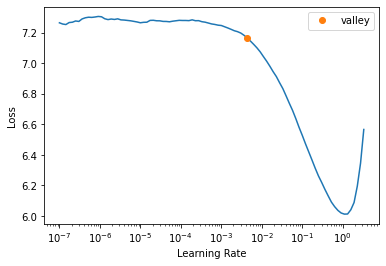

In [28]:
def get_lm(dls, backwards=False): return language_model_learner(dls, AWD_LSTM, backwards=backwards, metrics=accuracy).to_fp16()
lm_dls_fwd = get_lm_dls(lm_df)
learn = get_lm(lm_dls_fwd)
lr = learn.lr_find().valley * 3

モデルの学習後にエンコーダー(特徴を学習した重み)を`save_encoder`関数で保存します。保存された重みは後の分類モデルに使用します。イメージとしては、転移学習に使用する重み(body部分)をエンコーダー、タスク特化(head部分)をデコーダーとしています。

In [29]:
learn.fine_tune(5, lr, wd=0.03)

encoder_fwd = "finetuned_fwd"
learn.save_encoder(encoder_fwd)

epoch,train_loss,valid_loss,accuracy,time
0,4.894755,3.455431,0.434462,00:48


epoch,train_loss,valid_loss,accuracy,time
0,3.399031,3.135214,0.465234,00:54
1,3.160096,2.973533,0.480371,00:54
2,2.953800,2.897537,0.491265,00:54
3,2.806697,2.863158,0.496669,00:54
4,2.717759,2.859203,0.497114,00:55


## 3. (言語モデルのembeddingを用いた)分類モデルの作成

分類モデル用のデータを用意・表示します。ポイントは、先の言語モデル用のデータの単語インデックス(`learn.dls.vocab`)を分類データに渡すことです。埋め込み行列の重みと合わせて、その重みに対応するインデックスの二点が転移学習には必要です。

In [30]:
dls = get_cls_dls(trn_df, vocab=learn.dls.vocab)
dls.show_batch(max_n=2)

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0


データの用意後、分類モデルを作成し学習を始めます。`learn.load_encoder`関数で、先に言語モデルで学習済みのエンコーダーが使用されます。この関数はin placeで中身が変更される訳ではないので、`learn = learn.load_encoder(enc_name)`とlearnオブジェクトにアサインし直す点が注意点です。

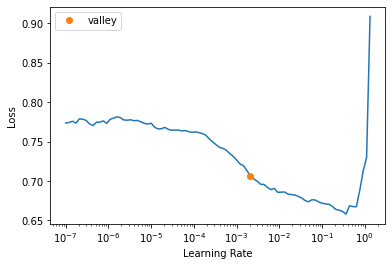

In [31]:
learn = get_classifier(dls)
learn = learn.load_encoder(encoder_fwd)
lr = learn.lr_find().valley * 2

分類モデルの学習のコツとしては、曖昧な言い方になってしまうのですが、regularization(weight decay、dropoutなど)の値をすこし大きめにして急な重みの変更を防ぐことが大事な点です。gradual unfreezingなど、すこしずつ学習パラメータを更新していくのも効果的です。モデルの学習後保存された予測は、後のbackwardモデルの予測と合わせて使用されます。

In [32]:
learn.fine_tune(8, lr, wd=0.1)
preds_fwd = learn.get_preds(dl=learn.dls.test_dl(tst_df))[0]

epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.631536,0.490496,1.633126,0.715162,00:05


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.556292,0.434031,1.543466,0.743438,00:08
1,0.549099,0.433473,1.542605,0.742373,00:09
2,0.536447,0.420319,1.522446,0.757806,00:08
3,0.525258,0.418725,1.520023,0.769992,00:08
4,0.514848,0.410053,1.506898,0.765743,00:08
5,0.505388,0.406269,1.501207,0.765558,00:08
6,0.496640,0.406081,1.500925,0.771165,00:08
7,0.489019,0.407071,1.502410,0.777870,00:07


では、同様の学習プロセスをbackwardモデルに対して行います。それぞれのデータ・モデル作成の際に`backward=True`を設定する点以外は、以下同様の流れです。

--

* 言語モデル用のデータを用意
* 言語モデルの学習
* 分類モデル用のデータを用意
* 分類モデルの学習
* テストデータの予測を保存

In [33]:
# Train language model
learn = get_lm(get_lm_dls(lm_df, backwards=True), backwards=True)
learn.fine_tune(5, 1e-2, wd=0.03)
# Save encoder
encoder_bwd = "finetuned_bwd"
learn.save_encoder(encoder_bwd)
# Train classifier model
learn = get_classifier(get_cls_dls(trn_df, vocab=learn.dls.vocab, backwards=True), backwards=True)
learn = learn.load_encoder(encoder_bwd)
learn.fine_tune(8, lr, wd=0.1)
# Create predictions
preds_bwd = learn.get_preds(dl=learn.dls.test_dl(tst_df))[0]

epoch,train_loss,valid_loss,accuracy,time
0,5.003757,3.516969,0.443088,00:56


epoch,train_loss,valid_loss,accuracy,time
0,3.499081,3.194522,0.476682,01:01
1,3.247958,2.986923,0.503277,01:01
2,3.052398,2.890414,0.517437,01:01
3,2.888596,2.851655,0.523188,01:01
4,2.810168,2.845774,0.524599,00:59


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.613130,0.488577,1.629995,0.738382,00:06


epoch,train_loss,valid_loss,perplexity,f1_score,time
0,0.521553,0.444249,1.559318,0.746575,00:08
1,0.511456,0.431926,1.540222,0.747215,00:08
2,0.503932,0.432837,1.541625,0.765705,00:08
3,0.493339,0.416256,1.516273,0.767263,00:08
4,0.483225,0.424038,1.528120,0.773378,00:08
5,0.471932,0.423141,1.526750,0.773311,00:08
6,0.463045,0.417851,1.518695,0.769629,00:08
7,0.455804,0.414895,1.514211,0.762653,00:08


二つのモデルの予測値を平均して、最終スコアを取得します。二つのモデル(forward・backward)を合わせたテクニックは、NLPのTTA(Test-Time Augmentation)の一種に近いなと個人的には感じます。

In [34]:
smp_df["target"] = torch.max(preds_fwd + preds_bwd, dim=-1).indices
smp_df.to_csv(path/"submission.csv", index=False)
!head {path}/submission.csv

id,target
0,1
2,1
3,1
9,1
11,1
12,1
21,0
22,0
27,0


In [35]:
from kaggle import api
api.competition_submit_cli(path/"submission.csv", "fwd+bwd model", comp)

100%|██████████| 22.2k/22.2k [00:00<00:00, 67.9kB/s]


Successfully submitted to Natural Language Processing with Disaster Tweets

最後に、使用したデータのファイル・フォルダーを削除します。

In [36]:
!rm -rf {path}
!rm nlp-getting-started.zip

## 4. まとめ

![kaggle の結果](result.png "kaggleの結果")


もしも読者がこのノートを役に立ったと思ったら、リアクションボタンを押してもらえると幸いです。質問や間違いがあれば、以下コメント欄に書き込んでください。

## 5.参照リンク

* [追加のtweetデータセット]()
* [ulmfitの論文](https://arxiv.org/abs/1801.06146)
* [fastai NLP チュートリアル](https://docs.fast.ai/tutorial.text.html)
* [前回の記事]()